# CORD-19 Research [task 1: Population]

This notebook is for task 1 only

# PART 1: Introduction

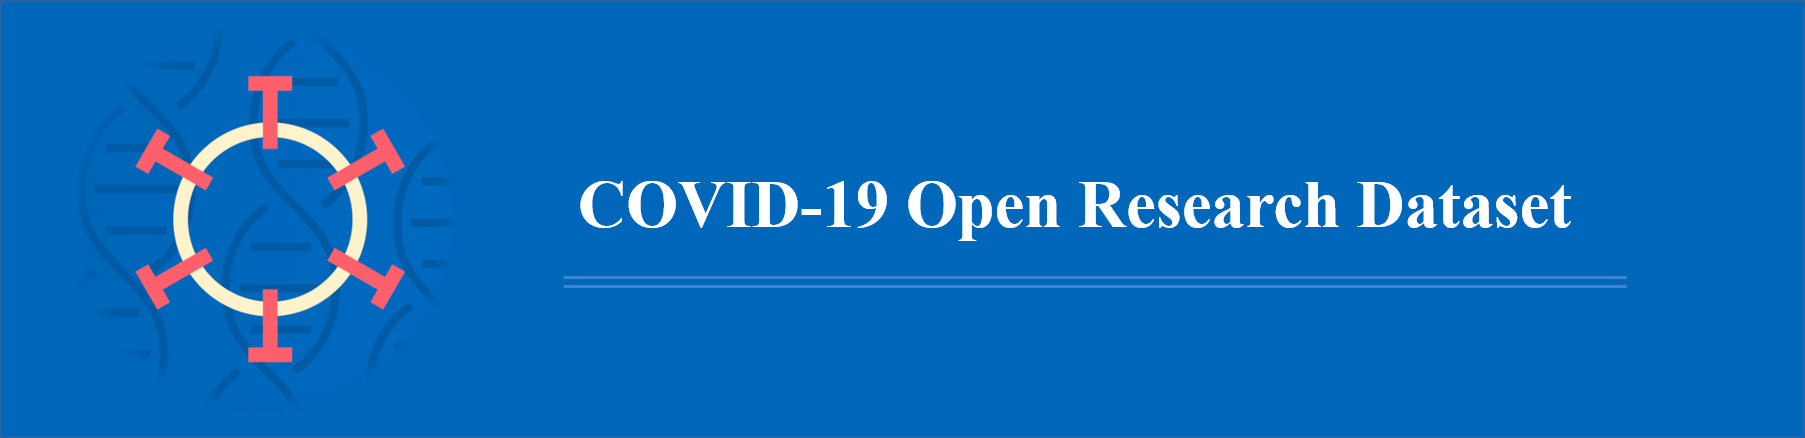

With the ongoing development of COVID-19 situation, the number of research publications on it has been growing rapidly, making it increasingly difficult for researchers to locate the most relevant findings for their topics. This project aims to help the medical community find the information they seek by building data mining and search tools, which can ultimately support the ongoing fight against this pandemic. This notebook contains a basic pipeline of using NLP models and keyword searching to find answers to high priority scientific questions regarding the COVID-19.

# PART 2: Process

## Step 1: Import Packages & Helper Functions

- Function `format_name(author)`, `format_affiliation(affiliation)`, `format_authors(authors, with_affiliation=False)`, `format_body(body_text)`, and `format_bib(bibs)` each converts the paper-related information to standard format.
- Function `load_files(dirname)` loads the papers from json and saves them to a list.
- Function `clean_pdf_files(file_list, keyword_list)` takes a list of file and converts it to a dataframe with cleaned columns.
- Function `clean_sent(sentence)` cleans the text by lowercasing all words, removing numbers, punctuations, and stopwords, and stemming all words.
- Function `calc_simlarity_score(question_list, text_list,threshold=None, top=None)` calculates the similarity score between the TF-IDF matrix of the article and that of questions.
- Function `retrieve_paper(df, dic)` retrieves the information of relevant papers for each question in the specific topic.


The script for loading papers is based on: https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv

The code for TF-IDF cosine similarity is based on: https://github.com/mbulusu/Duplicate-Document-Detection-Meetup-Presentation

In [ ]:
# Import Packages
import os
import re
import nltk
import json
import torch
import nltk.corpus  
import pandas as pd
import numpy as np
from copy import deepcopy
from nltk.stem import PorterStemmer
from datetime import datetime
from datetime import timedelta
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('stopwords')

from pathlib import Path

In [ ]:

# Text Preprocessing `clean_sent()`----------------------------------------------------------------------
porter_stemmer = PorterStemmer()
def clean_sent(sentence):
    """
    Clean the sentence
    :param sentence: text to to be cleaned
    :return: text that has been cleaned
    """
    #nltk.FreqDist(words).most_common(10)
    stopwords = set(nltk.corpus.stopwords.words('english'))
    words = sentence.split()
    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]
    #words = sentence
    words = [word for word in words if len(word) > 1]
    # Remove numbers
    words = [word for word in words if not word.isnumeric()]
    # Remove punctuation
    words = [word for word in words if word.isalpha()]
    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    # Porter
    words = [porter_stemmer.stem(word) for word in words]
    #fdist = nltk.FreqDist(words_lc)   
    return " ".join(words)


## Data Load----------------------------------------------------------------------
def format_name(author):
    middle_name = " ".join(author['middle'])
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])

def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))

    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []

    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)

    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}

    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"

    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []

    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'],
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)

    return raw_files

def clean_pdf_files(file_list, keyword_list):
    nth_paper=0
    cleaned_files=[]
    for file in file_list:
        with open(file) as f:
            file=json.load(f)
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'],
                           with_affiliation=True),
            format_body(file['abstract']),
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]
        if(nth_paper%1000)==0:
            print(nth_paper)
        nth_paper=nth_paper+1

        has_keyword = False
        for keyword in keyword_list:
            if keyword in features[5]:
                has_keyword = True
                break
        if has_keyword == True:
            cleaned_files.append(features)
    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text',
                 'bibliography','raw_authors','raw_bibliography']
    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    return clean_df


# Similarity ----------------------------------------------------------------------
def calc_simlarity_score(question_list, text_list,threshold=None, top=None):
    """
    Calculate the cosine similarity score for each pair of question and text with given questions and text
    
    :param question_list: a list - questions based on which the relevant articles are searched for 
    :param text_list: a list - the list of paper contents that the relevant articles are searched upon
    :param text_list: a list - the list of paper contents that the relevant articles are searched upon
    :param threshold: a decimal - the minimum cosine similarity score between questions and returned papers
    :param top: a number - the number of papers with highest score to be returned
    
    :return: dic - A dictionary with question index as key, and relevant paper index and similarity score as value
    :return: sim_matrix - A matrix with cosine similarity score of all pairs of questions and papers
    """
    if (threshold==None)  and  (top==None):
        raise ValueError("Parameter `threshold` and `top` cannot both be None")
    dic = {}
    tfidf = TfidfVectorizer()
    corpus_tfidf_matrix = tfidf.fit_transform(text_list)
    ques_tfidf_matrix = tfidf.transform(question_list)
    sim_matrix = cosine_similarity(corpus_tfidf_matrix, ques_tfidf_matrix)
    for ques_idx in range(sim_matrix.shape[1]):
        dic[ques_idx] = []
        if threshold != None:
            if (threshold>1) or (threshold <0):
                raise ValueError("Please enter a value from 0 to 1 for parameter `threshold`")
            for paper_idx in range(sim_matrix.shape[0]):
                score = sim_matrix[paper_idx, ques_idx]
                if score >= threshold:
                    dic[ques_idx].append((paper_idx, score))
            dic[ques_idx]=sorted(dic[ques_idx], key=lambda i: i[1], reverse=True)
        elif top != None:
            top_paper_idx_list = sorted(range(len(sim_matrix[:, ques_idx])), key=lambda i: sim_matrix[:,0][i], reverse=True)[:top]
            dic[ques_idx] = [(top_idx, sim_matrix[top_idx, ques_idx]) for top_idx in top_paper_idx_list]
    return dic, sim_matrix

# Retrieve relevant paper----------------------------------------------------------------------
def retrieve_paper(df, dic):
    df_dic={}
    for ques_idx in dic:
        new_df = df.iloc[[item[0] for item in dic[ques_idx]], :]
        new_df['score'] = [item[1] for item in dic[ques_idx]]
        new_df['question'] = questions[ques_idx]
        df_dic[ques_idx]=new_df.copy()
    return df_dic


## Step 2: Load Data

This part of the code is based on https://www.kaggle.com/tizili0307/research-documentation

### 2.1 Load covid-19 relevant papers into dataframe

### Load relevant papers
- Load the papers and related information to the data structure.
- Filter the papers to only articles related to COVID-19.

In [ ]:
# Set parameters
path = '/kaggle/input/CORD-19-research-challenge/document_parses/pdf_json'
keyword_list = ['novel coronavirus', 'novel-coronavirus', 'coronavirus-2019', 
                'sars-cov-2', 'sarscov2', 'covid-19', 'covid19',
                '2019ncov', '2019-ncov', 'wuhan']

# Get list of file paths
file_list = [os.path.join(r, file)  for r, _, f in os.walk(path)  for file in f]

# Clean （This takes ~15 min）
clean_pdf_df = clean_pdf_files(file_list, keyword_list)

### 2.2 Combine selected papers with the metadata¶

In [ ]:
# Append additional info from metadata to main df
metadata = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
clean_pdf_df = clean_pdf_df.merge(metadata[['sha', 'title', 'authors', 'abstract', 'doi', 'publish_time', 'journal']], 
                                  how ='left', left_on='paper_id', right_on='sha')

# Clean columns
clean_pdf_df['title_x'] = clean_pdf_df['title_x'].fillna(clean_pdf_df['title_y'])
clean_pdf_df['authors_x'] = clean_pdf_df['authors_x'].fillna(clean_pdf_df['authors_y'])
clean_pdf_df['abstract_x'] = clean_pdf_df['abstract_x'].fillna(clean_pdf_df['abstract_y'])
clean_pdf_df = clean_pdf_df.drop(['sha', 'title_y', 'authors_y', 'abstract_y'], axis=1)
clean_pdf_df = clean_pdf_df.rename(columns={'title_x': 'title', 'authors_x': 'authors', 'abstract_x': 'abstract'})

### 2.3 Data preprocessing

- Use lowercase for all content
- Remove numbers, punctuations, stopwords
- Remove the commoner morphological and inflexional endings from words in English

In [ ]:
clean_pdf_df['text_cleaned'] = clean_pdf_df.apply(lambda row: clean_sent(row['text']), axis=1)

### 2.4 (Optional) Save dataframe

In [ ]:
clean_pdf_df.to_pickle(("/kaggle/working/clean_pdf_df.pkl"))
# clean_pdf_df = pd.read_pickle("/kaggle/working/clean_pdf_df.pkl")

## Step 3: Paper Selection by `Cosine Similarity`

Note: Based on https://www.kaggle.com/tizili0307/research-documentation

The relevant papers for each question are selected by calculating the cosine similarity score based on the TF-IDF pair of articles and questions.

TF-IDF is a statistical measure that evaluates how important a word is to a document when compared against the other document in the corpus. In this project, both articles and questions are converted to TF-IDF matrix so that the information can be captured with fewer words and can be used for calculation.

Cosine similarity is a commonly used metric to measure the similarity between two vectors by taking the dot product divided by the product of two vector’s length. In this project, cosine similarity is used to measure the similarity between the TF-IDF matrix pair of documents and questions. In this way, the level of relevance can be quantified, which ultimately helps us to identify the most relevant papers for each question against more than 6,000 articles.

Find questions

In [ ]:
# set text
text_cleaned = clean_pdf_df['text_cleaned']

# set questions
path = '/kaggle/input/CORD-19-research-challenge/Kaggle/target_tables/1_population/'
file_list = sorted(list(Path(path).glob('*.csv')))
questions = [file.name.split(".csv")[0].strip('_') for file in file_list]
for i,q in enumerate(questions):
    print("Question" ,i + 1,":",q)

### Reprasing questions to include more keywords

In [ ]:
questions_alt = [
    'How are patients from poorer areas or lower socialeconomic status or live in proverty managed',
    'How to reach marginalized, rural, low-income and disadvantaged populations',
    'How to control the spread in communities',
    'How to communicate with target high risk population',
    'How to combat and overcome resource failures or shortages',
    'How to create hospital infrastructure to prevent nosocomial outbreaks',
]

In [ ]:
# questions_cleaned = [clean_sent(ques) for ques in questions]
questions_cleaned = [clean_sent(ques) for ques in questions_alt]

### 3.2 Select relevant papers by cosine similarity

In [ ]:
# Select relevant paper to 
dic, sim_matrix = calc_simlarity_score(questions_cleaned, text_cleaned, threshold=0.13)#, top=10)
relevant_paper_dic = retrieve_paper(clean_pdf_df, dic)

In [ ]:
[relevant_paper_dic[i].shape[0] for i in relevant_paper_dic.keys()]

### 3.3 Add common columns to all ****target tables

In [ ]:
file_list = [os.path.join(r, file)  for r, _, f in os.walk(path)  for file in f]
table_cols_dic={}
table_dic={}
target_table_dic={}
for i,file in enumerate(file_list):
    df=pd.read_csv(file)
    cols=list(df.columns)
    table_cols_dic[i]=cols[1:]
    table_dic[i]=df
    target_table_dic[i]=pd.DataFrame(columns=cols)
_ = [print(table_cols_dic[key]) for key in table_cols_dic.keys()]

In [ ]:
for key in target_table_dic.keys():
    target_table_dic[key][['Date', 'Study', 'Journal']] = relevant_paper_dic[key][['publish_time', 'title', 'journal']]
    target_table_dic[key]['Study Link'] = "https://doi.org/" + relevant_paper_dic[key]['doi']
    relevant_paper_dic[key]=relevant_paper_dic[key].reset_index(drop=True)
    target_table_dic[key]=target_table_dic[key].reset_index(drop=True)
    target_table_dic[key]['Added on'] = "10-Jun-2020"

In [ ]:
STUDY_TYPES = [
    char.lower() for char in [
        'Systematic review', 
        'meta-analysis', 
        'Prospective observational', 
        'Retrospective observational', 
        'Observational', 
        'Cross-sectional', 
        'Case series', 
        'Expert review', 
        'Editorial', 
        'Simulation', 
    ]
]

# Step 4: Create target table for questions

### [Q1] "Management of patients who are underhoused or otherwise lower social economic status"

#### Conclusion


In [ ]:
index = 0

In [ ]:
print(questions[index])
print(questions_alt[index])

In [ ]:
excerpt_list=[]
for i, row in relevant_paper_dic[index].iterrows():    
    # Divide to sentences
    sent_list = [sent.strip(' ') for sent in re.split(' \.|\.(?=[A-Z])|\. (?=[A-Z])|\n', row['text'])]
    
    
    # Find relevant sentences
    relevant_sent_list = [
        sent for sent in sent_list 
        if any([kw in sent.lower() for kw in [
            'underhoused', 'poor', 'underpaid', 'socialeconomic', 'proverty', 'unemployed', 'low income', 'no income', 'disparities', 
            'metropolitan'
        ]])
    ]
    print(f"# relevant sentences: {len(relevant_sent_list)}")
    # Join sentences to form excerpt
    excerpt_string = '; \n'.join([sent for sent in relevant_sent_list])
    excerpt_list.append(excerpt_string)
    
target_table_dic[index]["Excerpt"]=excerpt_list

- Target Table Overview

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
target_table_dic[index] = target_table_dic[index][target_table_dic[index]['Excerpt'].str.len().gt(0)]

In [ ]:
target_table_dic[index] = target_table_dic[index].iloc[:2, 1:]

### Manual work

In [ ]:
target_table_dic[index].loc[target_table_dic[index].index == 1, 'Study'] = "Letter to the Editor"

In [ ]:
target_table_dic[index].loc[:, 'Addressed Population'] = [
    'urban and rural elderly people',
    'rural areas of the USA',
]
target_table_dic[index].loc[:, 'Challenge'] = [
    'Profound health disparities exist in the time of emerging epidemic',
    'The trickle-down effect for people with CF living in poorly-resourced rural counties with limited financial capital and limited pathways for individual economic and social advancement may be significant',
]

target_table_dic[index].loc[:, 'Proposed Solution'] = [
    'Health care providers, especially those serving vulnerable population, should be vigilant about undiagnosed patients',
    'None proposed',
]
target_table_dic[index].loc[:, 'Measure of Evidence'] = [
    'p=0.01 and p=0.05',
    'None provided',
]

In [ ]:
study_types = []
for i, row in target_table_dic[index].iterrows():
    paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['doi'] == row['Study Link'][16:]].iloc[0]
    for st in STUDY_TYPES:
        if st in paper_data['text'].lower():
            study_types.append(st)
            break
print(study_types)

In [ ]:
target_table_dic[index]

### [Q2] "Measures to reach marginalized and disadvantaged populations"

In [ ]:
index = 1

In [ ]:
print(questions[index])
print(questions_alt[index])

In [ ]:
excerpt_list=[]
for i, row in relevant_paper_dic[index].iterrows():    
    # Divide to sentences
    sent_list = [sent.strip(' ') for sent in re.split(' \.|\.(?=[A-Z])|\. (?=[A-Z])|\n', row['text'])]
    
    
    # Find relevant sentences
    relevant_sent_list = [
        sent for sent in sent_list 
        if any([kw in sent.lower() for kw in [
            'marginalize', 'disadvantage', 'poverty', 'reach', 'statistical significan', 'confidence interval'
        ]])
    ]
    print(f"# relevant sentences: {len(relevant_sent_list)}")
    # Join sentences to form excerpt
    excerpt_string = '; \n'.join([sent for sent in relevant_sent_list])
    excerpt_list.append(excerpt_string)
    
target_table_dic[index]["Excerpt"]=excerpt_list

### Manual work

In [ ]:
study_types = []
for i, row in target_table_dic[index].iterrows():
    paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['doi'] == row['Study Link'][16:]].iloc[0]
    for st in STUDY_TYPES:
        if st in paper_data['text'].lower():
            study_types.append(st)
            break
print(study_types)

In [ ]:
target_table_dic[index].loc[:, 'Study Type'] = [
    'Systematic review and meta-analysis',
]
target_table_dic[index].loc[:, 'Addressed Population'] = [
    'vulnerable and disadvantaged populations',
]
target_table_dic[index].loc[:, 'Challenge'] = [
    'When the distribution of power, money, and resources systematically disadvantages some individuals and groups, this leads to avoidable differences in health outcomes, referred to as health inequity, within countries but also between countries',
]

target_table_dic[index].loc[:, 'Solution'] = [
    'None proposed',
]
target_table_dic[index].loc[:, 'Measure of Evidence'] = [
    'None provided',
]

In [ ]:
target_table_dic[index]

### [Q3] "Methods to control the spread in communities"

In [ ]:
index = 2

In [ ]:
print(questions[index])
print(questions_alt[index])

In [ ]:
excerpt_list=[]

for i, row in relevant_paper_dic[index].iterrows():    
    # Divide to sentences
    sent_list = [sent.strip(' ') for sent in re.split(' \.|\.(?=[A-Z])|\. (?=[A-Z])|\n', row['text'])]
    
    
    # Find relevant sentences
    relevant_sent_list = [
        sent for sent in sent_list 
        if any([re.search(pat, sent.lower()) is not None for pat in [
            '(control)(.*)(spread)', '(spread)(.*)( communit)', '(control)(.*)(virus)', '(virus)(.*)(communit)'
        ]])
    ]
    if len(relevant_sent_list) > 0:
        relevant_sent_list += [
        sent for sent in sent_list 
        if (any([re.search(pat, sent.lower()) is not None for pat in [
            "(statistical)(.*)(signific)", "confidence interval", "evidence"
        ]])) and not sent in relevant_sent_list
    ]
    print(f"# relevant sentences: {len(relevant_sent_list)}")
    # Join sentences to form excerpt
    excerpt_string = '; \n'.join([sent for sent in relevant_sent_list])
    excerpt_list.append(excerpt_string)
    
target_table_dic[index]["Excerpt"]=excerpt_list

In [ ]:
target_table_dic[index] = target_table_dic[index][target_table_dic[index]['Excerpt'].str.len().gt(0)]

In [ ]:
target_table_dic[index] = target_table_dic[index].iloc[:15, :]

In [ ]:
target_table_dic[index] = target_table_dic[index].iloc[[i for i in range(15) if i != 3], :]

In [ ]:
target_table_dic[index].loc[target_table_dic[index].index == 4, 'Study'] = "Community pharmacist in public health emergencies: Quick to action against the coronavirus 2019-nCoV outbreak"
target_table_dic[index].loc[target_table_dic[index].index == 4, 'Journal'] = "Elsevier Public Health Emergency Collection"
target_table_dic[index].loc[target_table_dic[index].index == 4, 'Study Link'] = "https://doi.org/10.1016/j.sapharm.2020.02.003"

In [ ]:
target_table_dic[index] = target_table_dic[index].iloc[[i for i in range(14) if i != 9], :]

In [ ]:
target_table_dic[index].loc[target_table_dic[index].index == 16, 'Study'] = "Editorial: The explosive epidemic outbreak of novel coronavirus disease 2019 (COVID-19) and the persistent threat of respiratory tract infectious diseases to global health security"
target_table_dic[index].loc[target_table_dic[index].index == 16, 'Journal'] = "Current Opinion in Pulmonary Medicine"

### Manual work

In [ ]:
study_types = []
for i, row in target_table_dic[index].iterrows():
    try:
        if pd.isnull(row['Study Link']):
            paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['title'] == row['Study']].iloc[0]
        else:
            paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['doi'] == row['Study Link'][16:]].iloc[0]
        found = False
        for st in STUDY_TYPES:
            if st in paper_data['text'].lower():
                study_types.append(st)
                found = True
                break
        if not found:
            study_types.append(None)
    except:
        study_types.append(None)
print(study_types)

In [ ]:
study_types[1] = "Systematic review and meta-analysis"
study_types[11] = "Editorial"
target_table_dic[index].loc[:, 'Study Type'] = study_types
target_table_dic[index].loc[:, 'Addressed Population'] = [
    'Not specified',
    "Not specified",
    "Not specified",
    "England and Wales",
    "Not specified",
    "China",
    "United States",
    "Not specified",
    "Not specified",
    "Not specified",
    "Not specified",
    "haematology patients",
    "China",
]
target_table_dic[index].loc[:, 'Challenge'] = [
    'Contain the spread of virus',
    "epidemic prevention and control",
    'avoid or minimize the last stage of "community transmission"',
    "containing outbreaks",
    "SARS-CoV-2 probably started to spread locally long before community transmission was officially recognized and control measures for social distancing and air travel restrictions were implemented",
    "prevent and control the spread of COVID -19 in China",
    "Healthcare disparities and challenges",
    "prevent spread from imported cases and re-establishment of community transmission",
    "contain community transmission", 
    "prevention and control of SARS Coronavirus-2 disease",
    "public health infection control",
    "reduce haematology patients' risk during ongoing care in the middle of COVID-19",
    "control the spread of the epidemic",
]

target_table_dic[index].loc[:, 'Solution'] = [
    'the international community, by contrast, views virus sharing as a critical element of risk communication and, by extension, a global risk management issue',
    "This indicates that after controlling other factors affecting the COVID-19, the spread of information has significantly reduced the spread of COVID-19 in the country; ",
    "Routine hand hygiene is essential for preventing the spread of the virus and requires the correct use of alcohol-based formulation.\nHowever, community pharmacists encountered a major issue soon after the news about the potential spread of 2019-CoV to the citya foreseeable short supply of hand hygiene products which were all imported products",
    "imposing additional targeted lockdowns or mass-testing at the community-level can be effective at containing outbreaks",
    "the mortality rate will probably not exceed 1% of the total number of infected individuals.",
    "In the prevention and control of the COVID-19 epidemic, traffic control and social distancing measures have played a very good role in controlling the spread of the epidemic, but it also makes it difficult to deliver supplies equipment and humanitarian aid to the affected areas",
    "we need to engage communities to make it more of a reality for all Americans",
    "Suppression measures can keep transmission and prevalence low, decreasing the effective reproduction number (R e ). 36 Once R e is below 1 in a community, spread in that community should eventually stop; ",
    "community quarantine is also needed with rigorous implementation of social distancing",
    "we simulate the optimal systems when all the three control variables (such as educational campaign, social distancing and treatment control) for coronavirus-2 disease (COVID 19) are employed",
    "A specific molecular test for SARS-CoV-2 was developed and a flurry of investigations and research on COVID-19 outbreak rapidly defined the epidemiological, virologic, and clinical features and provided evidence of humanto-human transmission in community, household, and hospital settings",
    "In the case of widespread community infection and substantial pressures on hospitals, it will be hard to justify the prolonged immunosuppression, close follow-up and additional demands on hospital services that come with performing allogeneic (and to a lesser extent, autologous) bone marrow transplants",
    "The Wuhan closure, work stoppage, school suspension and community closed management, as well as the first-level response to major public health events launched nationwide, are measures that effectively controlled the movement of people and the spread of the epidemic; ",
]
target_table_dic[index].loc[:, 'Measure of Evidence'] = [
    'None provided',
    "statistically significant",
    'None provided',
    'None provided',
    'None provided',
    "None provided",
    "None provided",
    "None provided",
    "None provided",
    "None provided",
    "None provided",
    "None provided",
    "None provided",
]

In [ ]:
target_table_dic[index]

### [Q4] "Modes of communicating with target high-risk populations"

In [ ]:
index = 3

In [ ]:
print(questions[index])
print(questions_alt[index])

In [ ]:
excerpt_list=[]
for i, row in relevant_paper_dic[index].iterrows():    
    # Divide to sentences
    sent_list = [sent.strip(' ') for sent in re.split(' \.|\.(?=[A-Z])|\. (?=[A-Z])|\n', row['text'])]
    
    
    # Find relevant sentences
    relevant_sent_list = [
        sent for sent in sent_list 
        if any([re.search(pat, sent.lower()) is not None for pat in [
            '(communicat)(.*)(target)', '(communicat)(.*)(high[- ]risk)', '(communicat)(.*)(vulnerable)', '(communicat)(.*)(population)'
        ]])
    ]
    if len(relevant_sent_list) > 0:
        relevant_sent_list += [
        sent for sent in sent_list 
        if (any([re.search(pat, sent.lower()) is not None for pat in [
            "(statistical)(.*)(signific)", "confidence interval", "evidence"
        ]])) and not sent in relevant_sent_list
    ]
    print(f"# relevant sentences: {len(relevant_sent_list)}")
    # Join sentences to form excerpt
    excerpt_string = '; \n'.join([sent for sent in relevant_sent_list])
    excerpt_list.append(excerpt_string)
    
target_table_dic[index]["Excerpt"]=excerpt_list

In [ ]:
target_table_dic[index] = target_table_dic[index][target_table_dic[index]['Excerpt'].str.len().gt(0)]

In [ ]:
target_table_dic[index] = target_table_dic[index].iloc[[1], :]

### Manual work

In [ ]:
study_types = []
for i, row in target_table_dic[index].iterrows():
    try:
        if pd.isnull(row['Study Link']):
            paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['title'] == row['Study']].iloc[0]
        else:
            paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['doi'] == row['Study Link'][16:]].iloc[0]
        found = False
        for st in STUDY_TYPES:
            if st in paper_data['text'].lower():
                study_types.append(st)
                found = True
                break
        if not found:
            study_types.append(None)
    except:
        study_types.append(None)
print(study_types)

In [ ]:
target_table_dic[index].loc[:, 'Study Type'] = study_types
target_table_dic[index].loc[:, 'Addressed Population'] = ["marginalized patient populations and families"]
target_table_dic[index].loc[:, 'Challenge'] = [
    'patients and families might feel abandoned, as well as how poor communication and lack of resources to attend to psychosocial needs are often overlooked in life-threatening illness',
]

target_table_dic[index].loc[:, 'Solution'] = [
    "when communities finally got involved, not only in research and intervention design, but also in the implementation and the evaluation of solutions, and in building trust in the community about the recommendations for protection", 
]
target_table_dic[index].loc[:, 'Measure of Evidence'] = [
    'None provided',
]

In [ ]:
target_table_dic[index]

### [Q5] "What are recommendations for combating_overcoming resource failures

In [ ]:
index = 4

In [ ]:
print(questions[index])
print(questions_alt[index])

In [ ]:
excerpt_list=[]
for i, row in relevant_paper_dic[index].iterrows():    
    # Divide to sentences
    sent_list = [sent.strip(' ') for sent in re.split(' \.|\.(?=[A-Z])|\. (?=[A-Z])|\n', row['text'])]
    
    
    # Find relevant sentences
    relevant_sent_list = [
        sent for sent in sent_list 
        if any([re.search(pat, sent.lower()) is not None for pat in [
            '(resource)(.*)(fail)', '(resource)(.*)(short)', '(combat)(.*)(fail)', '(overcom)(.*)(fail)', '(short)(.*)(resource)'
        ]])
    ]
    if len(relevant_sent_list) > 0:
        relevant_sent_list += [
        sent for sent in sent_list 
        if (any([re.search(pat, sent.lower()) is not None for pat in [
            "(statistical)(.*)(signific)", "confidence interval", "evidence", 'population'
        ]])) and not sent in relevant_sent_list
    ]
    print(f"# relevant sentences: {len(relevant_sent_list)}")
    # Join sentences to form excerpt
    excerpt_string = '; \n'.join([sent for sent in relevant_sent_list])
    excerpt_list.append(excerpt_string)
    
target_table_dic[index]["Excerpt"]=excerpt_list

In [ ]:
target_table_dic[index] = target_table_dic[index][target_table_dic[index]['Excerpt'].str.len().gt(0)]

### Manual work

In [ ]:
study_types = []
for i, row in target_table_dic[index].iterrows():
    try:
        if pd.isnull(row['Study Link']):
            paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['title'] == row['Study']].iloc[0]
        else:
            paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['doi'] == row['Study Link'][16:]].iloc[0]
        found = False
        for st in STUDY_TYPES:
            if st in paper_data['text'].lower():
                study_types.append(st)
                found = True
                break
        if not found:
            study_types.append(None)
    except:
        study_types.append(None)
print(study_types)

In [ ]:
target_table_dic[index].loc[:, 'Addressed Population'] = ["Not specified"]
target_table_dic[index].loc[:, 'Challenge'] = ["The surge in infections has led to a severe shortage of medical resources"]
target_table_dic[index].loc[:, 'Solution'] = ["Besides, we observe that there are only two possible stationary state: the whole healthy and the whole infected of the population"]
target_table_dic[index].loc[:, 'Measure of Evidence'] = ["Not provided"]

In [ ]:
target_table_dic[index]

### [Q6] "What are ways to create hospital infrastructure to prevent nosocomial outbreaks"

In [ ]:
index = 5

In [ ]:
print(questions[index])
print(questions_alt[index])

In [ ]:
excerpt_list=[]
for i, row in relevant_paper_dic[index].iterrows():    
    # Divide to sentences
    sent_list = [sent.strip(' ') for sent in re.split(' \.|\.(?=[A-Z])|\. (?=[A-Z])|\n', row['text'])]
    
    
    # Find relevant sentences
    relevant_sent_list = [
        sent for sent in sent_list 
        if any([re.search(pat, sent.lower()) is not None for pat in [
            '(hospital)(.*)(infrastructure)', '(nosocomial)', '(infrastructure)(.*)(hospital)'
        ]])
    ]
    if len(relevant_sent_list) > 0:
        relevant_sent_list += [
        sent for sent in sent_list 
        if (any([re.search(pat, sent.lower()) is not None for pat in [
            "(statistical)(.*)(signific)", "confidence interval", "evidence"
        ]])) and not sent in relevant_sent_list
    ]
    print(f"# relevant sentences: {len(relevant_sent_list)}")
    # Join sentences to form excerpt
    excerpt_string = '; \n'.join([sent for sent in relevant_sent_list])
    excerpt_list.append(excerpt_string)
    
target_table_dic[index]["Excerpt"]=excerpt_list

In [ ]:
target_table_dic[index] = target_table_dic[index][target_table_dic[index]['Excerpt'].str.len().gt(0)]

In [ ]:
target_table_dic[index] = target_table_dic[index].iloc[:9, :]

In [ ]:
target_table_dic[index] = target_table_dic[index].iloc[[i for i in range(9) if i != 1], :]

In [ ]:
target_table_dic[index].loc[target_table_dic[index].index == 2, 'Study'] = "Inside China and COVID-19: Questions and answers"
target_table_dic[index].loc[target_table_dic[index].index == 2, 'Journal'] = "Elsevier Public Health Emergency Collection"
target_table_dic[index].loc[target_table_dic[index].index == 2, 'Study Link'] = "https://doi.org/10.1016/j.tmaid.2020.101640"

In [ ]:
target_table_dic[index] = target_table_dic[index].iloc[[i for i in range(8) if i != 5], :]

### Manual work

In [ ]:
study_types = []
for i, row in target_table_dic[index].iterrows():
    try:
        if pd.isnull(row['Study Link']):
            paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['title'] == row['Study']].iloc[0]
        else:
            paper_data = relevant_paper_dic[index][relevant_paper_dic[index]['doi'] == row['Study Link'][16:]].iloc[0]
        found = False
        for st in STUDY_TYPES:
            if st in paper_data['text'].lower():
                study_types.append(st)
                found = True
                break
        if not found:
            study_types.append(None)
    except:
        study_types.append(None)
print(study_types)

In [ ]:
target_table_dic[index].loc[:, 'Study Type'] = study_types
target_table_dic[index].loc[:, 'Addressed Population'] = [
    "SARS infected population",
    "China",
    "Hong Kong",
    "Thailand", 
    "Wuhan", 
    "Hong Kong", 
    "Hong Kong", 
]
target_table_dic[index].loc[:, 'Challenge'] = [
    "Nosocomial Transmission of SARS",
    "The implementation of standard precautions measures in the prevention and control of nosocomial infections was insufficient", 
    "nosocomial acquisition of SARS-CoV", 
    "A number of nosocomial outbreaks of MERS-CoV have been reported",
    "two separate nosocomial outbreaks of SARS-CoV-2 involving 20 medical staff in a hospital within one week", 
    "prevent importation and nosocomial transmission of SARS-CoV-2 in Hong Kong",
    "Nosocomial coronavirus infections", 
]

target_table_dic[index].loc[:, 'Solution'] = [
    "As noted, nosocomial transmission is highly efficient, and HCWs were sometimes the predominant victims",
    "From the perspective of nosocomial infection control, all medical staff must enquire about the epidemiological history of patients, particularly patients with fever and/or clinical characteristics of pneumonia; Only with all of these efforts coordinated can transmission of virus be cut within the family, the risk of nosocomial infections minimized, and the epidemic finally controlled.",
    "Administrative support to infection control is important to prevent nosocomial outbreak but it is not well studied in recent years [19]; With the support of hospital administration, the infrastructure of hospitals was improved from the period of SARS-CoV to SARS-CoV-2 by the provision of 1400 AIIRs in Hong Kong;",
    "Strict infection control precaution is the key to prevent nosocomial spread of emerging diseases",
    "Not Provided",
    "Vigilance in hand hygiene practice, wearing of surgical masks in the hospital, and appropriate use of PPE in patient care, especially performing AGPs, are the key infection control measures to prevent nosocomial transmission of SARS-CoV-2, even before the availability of effective antiviral agents and vaccine.; ",
    "This layout of distinct and separate sectors has proven efficient in the prevention of nosocomial RSV infections", 
]
target_table_dic[index].loc[:, 'Measure of Evidence'] = [
    "Not Provided",
    "Not Provided",
    "statistically significant", 
    "Not Provided",
    "Not Provided",
    "statistically significant",
    "Not Provided",
]

In [ ]:
target_table_dic[index]

# PART 3: Output & Summary

## Summary

### Q1: Management of patients who are underhoused or otherwise lower social economic status
- Challenges:
    - profound health disparities exist
        - medical resource in rural vs metropolitan areas
        - personal financial status
        - limited pathways for individual economic and social advancement
- Proposed Solutions:
    - Health care providers should be vigilant about undiagnosed patients

### Q2: Measures to reach marginalized and disadvantaged populations
- Challenges:
    - health inequality exsits not only within countries but also between countries
- Proposed Solutions:
    - None

### Q3: Methods to control the spread in communities
- Challenges:
    - Minimize community transmission
    - Reduce the risk for patients of other diseases
    - Public infection control
- Proposed Solutions:
    - recognize that virus sharing is a critical element of risk communication
    - spread of incormation can significantly reduce the spread of COVID-19
    - routine hand hygiene
    - Need to solve shortage of supply of hand hygiene products
    - targeted lockdowns or mess-testing at the community-level
    - Actual morality may by low, at around 1% (which suggests that the high morality might be due to shortage of hospital resources)
    - engage communicaties
    - Need to control R_0 at below 1 for the virus to eventually stop spreading
    - community quarantine and social distancing
    - better testing

### Q4: Modes of communicating with target high-risk populations
- Challenges:
    - poor communication and lack of resources are overlooked in life-threatening illness, and patients might feel abandoned
- Proposed Solution
    - involve the community, not only in research and intervention design, but also in the implementation and the evaluation of solutions, and in building trust in the community about the recommendations for protection

### Q5: What are recommendations for combating_overcoming resource failures
- Challenges:
    - The surge in infections has led to a severe shortage of medical resources
- Solution:
    - we observe that there are only two possible stationary state: the whole healthy and the whole infected of the population
    
### Q6: What are ways to create hospital infrastructure to prevent nosocomial outbreaks
- Challenges:
    - nosocomial outbreaks
- Proposed Solutions:
    - all medical staff must enquire about the epidemiological history of patients, particularly patients with fever and/or clinical characteristics of pneumonia
    - Administrative support to infection control
    - improve the hospital infastructure
    - Strict infection control precaution
    - Vigilance in hand hygiene practice, wearing of surgical masks in the hospital, and appropriate use of PPE in patient care, especially performing AGPs
    - Hospital layout of distinct and separate sectors
    
    
    
    
Contacts
- Kaitan Sun, kaitan9095@gmail.com
- Jiangxue Han, jxhan0317@gmail.com
- Richard Luo, ruize.luo@outlook.com
- Hanying Gan, hanying.gan@outlook.com

Reference
- The code for paper loading functions is based on: https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv
- The code for TF-IDF cosine similarity is based on: https://github.com/mbulusu/Duplicate-Document-Detection-Meetup-Presentation
- The code for Bert is based on: https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-

## Output

In [ ]:
for i in target_table_dic:
    target_table_dic[i].to_csv(f"/kaggle/working/table{i}_{questions[i]}.csv")